# Testing CNN Shape Measurement Responsivity of Simple Galaxy Models

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(config=config)
#print("Tensorflow version: {}".format(tf.version.VERSION))

#keras only after gpu ID and memory usage is set
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds
import autometacal as amc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Tensorflow version: 2.7.0


## Load Data

In [4]:
from autometacal.python.datasets import GalGen

In [5]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

reconv_psf = galsim.Moffat(beta=2.5, fwhm=0.9*1.2)

reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=51, ny=51, scale=.2).array),axis=0)
gal_images,psf_images = onebatch['obs_image'],onebatch['psf_image'] 

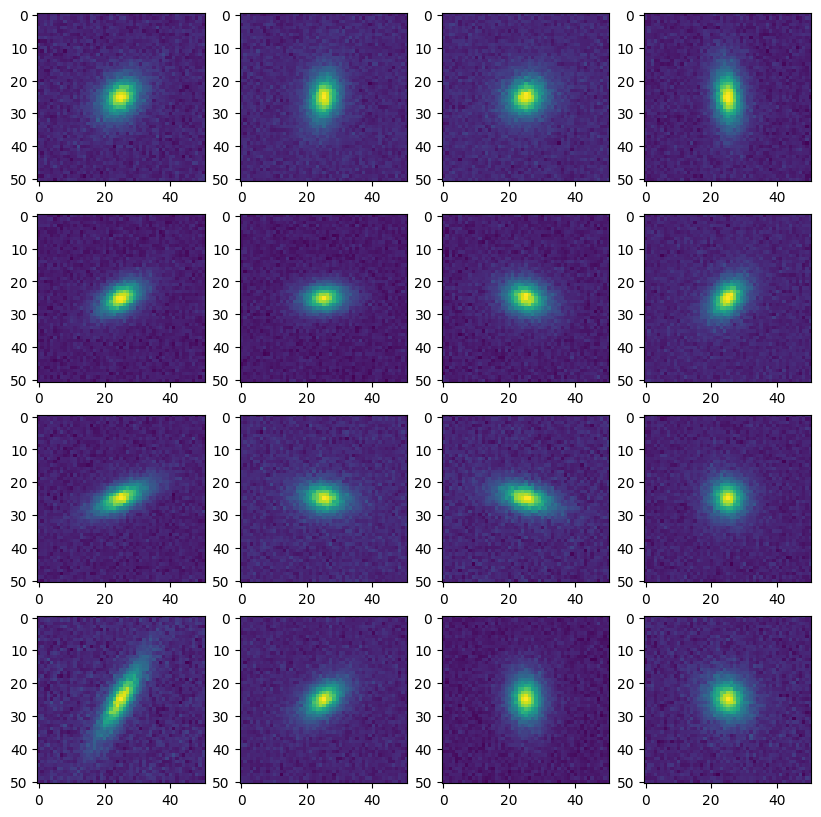

In [7]:
plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

### Test with finitediff

In [13]:
model = learnr.Ribli19(51,n_channels=1)

In [ ]:
loss = learnr.loss_fd(obs_batch,psf_batch,reconv_psf,model,shear_range=.1)

In [14]:
@tf.function
def step(batch,loss):
  
  
  with tf.GradientTape() as tape:
    tape.watch(newmodel.trainable_variables)
       
    lost = loss(batch,newmodel)
 
  grads = tape.gradient(lost, newmodel.trainable_variables)
  opt.apply_gradients(zip(grads, newmodel.trainable_variables))
  return lost

opt = ko.Adam(learning_rate=1e-4)

<tf.Tensor: shape=(), dtype=float32, numpy=11.313036>

In [ ]:
lost = []
its = []
iterations = 1000
for it in range(iterations):
  batch = batchit.next()
  nowlost = step(batch)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost.append(nowlost)
    its.append(it)  
model.save("RLmodel.model")

In [ ]:
style.use('ggplot')
plot(its,lost)
xlabel('iterations')
ylabel('loss')
savefig(f'learningRloss{time.time()}.png',bbox_inches='tight')

In [ ]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(10)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)

In [ ]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [ ]:
np.save("garray.npy",garray.numpy())
np.save("e_auto.npy",e_auto.numpy())
np.save("R_auto.npy",R_auto.numpy())

In [ ]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
mean(tf.linalg.inv(R_auto[:]),axis=0)

In [ ]:
figure(figsize=(20,10))
style.use('ggplot')
subplot(121)

x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


scatter(x1,y1-x1-mean(y1),alpha=.7,label="uncalibrated")
scatter(x1,y1corr-x1-mean(y1corr),alpha=.7,label="autometacal")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (uncorrected)".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)



title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y-x-\\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(122)

scatter(x2,y2-x2-mean(y2),alpha=.7,label="uncalibrated")
scatter(x2,y2corr-x2-mean(y2corr),alpha=.7,label="autometacal")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (uncorrected) ".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)

legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig(f"linearity{time.time()}.pdf",bbox_inches="tight")

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig(f'response_distribution_newmodel{time.time()}.pdf',bbox_inches='tight')

## New loss (apply shear before noise, PSF, etc.)

In [ ]:
import galflow as gf

In [ ]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)
batchit = data.as_numpy_iterator()

In [ ]:
import galflow as gf
@tf.function
def generate_real_mcal_image(
  gal_images,
  reconvolution_psf_image,
  g
):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  #psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32) 
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  padfactor = 3 #total width of image after padding
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  #psf_complex = tf.cast(padded_psf_images, tf.complex64)
  #psf_fft = tf.signal.fft2d(psf_complex)
  #psf_fft_abs = tf.abs(psf_fft)
  #psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  #kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)

  # Deconvolve image from input PSF
  im_deconv = imk * mask #* ( (1./(kpsf+1e-10))*mask)

  # Apply shear
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]

  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * krpsf * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  
  # Add noise
  img = img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]
  img += tf.random.normal([nx,ny],0,1e-6)

  return img

In [ ]:
style.use('default')
imshow(onebatch['gal_model'][0])

In [ ]:
teste=generate_real_mcal_image(onebatch['gal_model'][0][tf.newaxis],reconv_psf_image,[[0.0,0.5]])

In [ ]:
imshow(teste[0])

In [ ]:
@tf.function
def get_real_metacal_response_finitediff(gal_image,
                                    #psf_image,
                                    reconv_psf_image,
                                    shear,
                                    step,
                                    method):
  """
  Gets shear response as a finite difference operation, 
  instead of automatic differentiation.
  """
  batch_size, _ , _ = gal_image.get_shape().as_list()
  step_batch = tf.constant(step,shape=(batch_size,1),dtype=tf.float32)
  
  step1p = tf.pad(step_batch,[[0,0],[0,1]])
  step1m = tf.pad(-step_batch,[[0,0],[0,1]])
  step2p = tf.pad(step_batch,[[0,0],[1,0]])
  step2m = tf.pad(-step_batch,[[0,0],[1,0]])
    
  img0s = generate_real_mcal_image(
    gal_image,
    #psf_image,
    reconv_psf_image,
    tf.zeros([batch_size,2])
  ) 
  
  shears1p = shear + step1p
  img1p = generate_real_mcal_image(
    gal_image,
    #psf_image,
    reconv_psf_image,
    shears1p
  )
  
  shears1m = shear + step1m 
  img1m = generate_real_mcal_image(
    gal_image,
    #psf_image,
    reconv_psf_image,
    shears1m
  ) 
  
  shears2p = shear + step2p 
  img2p = generate_real_mcal_image(
    gal_image,
    #psf_image,
    reconv_psf_image,
    shears2p
  )
  
  shears2m = shear + step2m 
  img2m = generate_real_mcal_image(
    gal_image,
    #psf_image,
    reconv_psf_image,
    shears2m
  ) 
  
  g0s = method(img0s)
  g1p = method(img1p)
  g1m = method(img1m)
  g2p = method(img2p)
  g2m = method(img2m)
  
  R11 = (g1p[:,0]-g1m[:,0])/(2*step)
  R21 = (g1p[:,1]-g1m[:,1])/(2*step) 
  R12 = (g2p[:,0]-g2m[:,0])/(2*step)
  R22 = (g2p[:,1]-g2m[:,1])/(2*step)
 
  #N. B.:The matrix is correct. 
  #The transposition will swap R12 with R21 across a batch correctly.
  R = tf.transpose(tf.convert_to_tensor(
    [[R11,R21],
     [R12,R22]],dtype=tf.float32)
  )
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 

  return ellip_dict, R

In [77]:
newmodel = Ribli19(51)

In [78]:
@tf.function
def lossnewmodel(batch,model):
  
  shears = tf.random.uniform((batch_size,2),-.1,.1,dtype=tf.float32)
  #compute response
 
  R = get_real_metacal_response_finitediff(batch['gal_model'],
                                      reconv_psf_image,
                                      shear=shears,
                                      step=0.01,
                                      method=model)[1]
  
  lost = tf.norm(R - tf.eye(2)) 
  return lost, tf.reduce_mean(R,axis=0)

In [79]:
@tf.function
def stepnewmodel(batch):
  
  with tf.GradientTape() as tape:
    tape.watch(newmodel.trainable_variables)
       
    lost, meanR = lossnewmodel(batch,newmodel)
 
  grads = tape.gradient(lost, newmodel.trainable_variables)
  opt.apply_gradients(zip(grads, newmodel.trainable_variables))
  return lost, meanR
opt = ko.Adam(learning_rate=1e-4)

In [80]:
stepnewmodel(onebatch)

(<tf.Tensor: shape=(), dtype=float32, numpy=11.313708>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-1.07704686e-07, -3.59832271e-08],
        [ 2.28075251e-07,  1.03369445e-07]], dtype=float32)>)

In [81]:
lost2 = []
its2 = []
iterations = 10000
for it in range(iterations):
  batch = batchit.next()
  nowlost, meanR = stepnewmodel(batch)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost2.append(nowlost)
    its2.append(it)  


KeyboardInterrupt: 

In [82]:
stepnewmodel(onebatch)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.6802047>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[9.8195970e-01, 1.1026859e-04],
        [3.0219555e-03, 9.2186928e-01]], dtype=float32)>)

In [83]:
newmodel.save("RLnewmodelclipping.model")

INFO:tensorflow:Assets written to: RLnewmodelclipping.model/assets


INFO:tensorflow:Assets written to: RLnewmodelclipping.model/assets


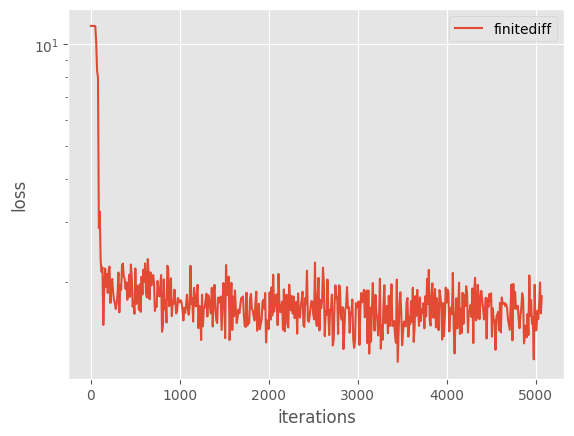

In [84]:
style.use('ggplot')
plot(its2,lost2,label='finitediff')
xlabel('iterations')
ylabel('loss')
yscale('log')
legend()
savefig(f'learningnewmodel4{time.time()}.png',bbox_inches='tight')

In [85]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(100)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,newmodel)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)  

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:03<05:55,  3.59s/it]

  2%|▏         | 2/100 [00:07<05:49,  3.57s/it]

  3%|▎         | 3/100 [00:10<05:44,  3.55s/it]

  4%|▍         | 4/100 [00:14<05:43,  3.58s/it]

  5%|▌         | 5/100 [00:17<05:41,  3.60s/it]

  6%|▌         | 6/100 [00:21<05:36,  3.58s/it]

  7%|▋         | 7/100 [00:25<05:57,  3.84s/it]

  8%|▊         | 8/100 [00:29<05:52,  3.83s/it]

  9%|▉         | 9/100 [00:33<05:47,  3.82s/it]

 10%|█         | 10/100 [00:37<05:44,  3.83s/it]

 11%|█         | 11/100 [00:40<05:34,  3.76s/it]

 12%|█▏        | 12/100 [00:44<05:26,  3.71s/it]

 13%|█▎        | 13/100 [00:48<05:21,  3.69s/it]

 14%|█▍        | 14/100 [00:52<05:30,  3.84s/it]

 15%|█▌        | 15/100 [00:55<05:20,  3.77s/it]

 16%|█▌        | 16/100 [00:59<05:12,  3.72s/it]

 17%|█▋        | 17/100 [01:03<05:06,  3.69s/it]

 18%|█▊        | 18/100 [01:06<04:59,  3.65s/it]

 19%|█▉        | 19/100 [01:10<04:54,  3.63s/it]

 20%|██        | 20/100 [01:13<04:49,  3.62s/it]

 21%|██        | 21/100 [01:17<04:48,  3.66s/it]

 22%|██▏       | 22/100 [01:21<04:55,  3.79s/it]

 23%|██▎       | 23/100 [01:25<04:48,  3.74s/it]

 24%|██▍       | 24/100 [01:28<04:41,  3.70s/it]

 25%|██▌       | 25/100 [01:32<04:34,  3.66s/it]

 26%|██▌       | 26/100 [01:36<04:28,  3.63s/it]

 27%|██▋       | 27/100 [01:39<04:25,  3.64s/it]

 28%|██▊       | 28/100 [01:43<04:25,  3.69s/it]

 29%|██▉       | 29/100 [01:47<04:35,  3.88s/it]

 30%|███       | 30/100 [01:51<04:24,  3.78s/it]

 31%|███       | 31/100 [01:55<04:17,  3.73s/it]

 32%|███▏      | 32/100 [01:58<04:10,  3.68s/it]

 33%|███▎      | 33/100 [02:02<04:04,  3.65s/it]

 34%|███▍      | 34/100 [02:05<03:59,  3.63s/it]

 35%|███▌      | 35/100 [02:09<03:55,  3.62s/it]

 36%|███▌      | 36/100 [02:12<03:50,  3.60s/it]

 37%|███▋      | 37/100 [02:17<03:55,  3.74s/it]

 38%|███▊      | 38/100 [02:20<03:49,  3.70s/it]

 39%|███▉      | 39/100 [02:24<03:43,  3.66s/it]

 40%|████      | 40/100 [02:27<03:40,  3.67s/it]

 41%|████      | 41/100 [02:31<03:38,  3.70s/it]

 42%|████▏     | 42/100 [02:35<03:31,  3.65s/it]

 43%|████▎     | 43/100 [02:38<03:25,  3.61s/it]

 44%|████▍     | 44/100 [02:42<03:27,  3.70s/it]

 45%|████▌     | 45/100 [02:46<03:19,  3.63s/it]

 46%|████▌     | 46/100 [02:49<03:13,  3.59s/it]

 47%|████▋     | 47/100 [02:53<03:08,  3.55s/it]

 48%|████▊     | 48/100 [02:56<03:03,  3.53s/it]

 49%|████▉     | 49/100 [03:00<02:59,  3.52s/it]

 50%|█████     | 50/100 [03:03<02:55,  3.51s/it]

 51%|█████     | 51/100 [03:07<02:52,  3.52s/it]

 52%|█████▏    | 52/100 [03:10<02:54,  3.63s/it]

 53%|█████▎    | 53/100 [03:14<02:49,  3.61s/it]

 54%|█████▍    | 54/100 [03:18<02:46,  3.62s/it]

 55%|█████▌    | 55/100 [03:21<02:42,  3.62s/it]

 56%|█████▌    | 56/100 [03:25<02:39,  3.62s/it]

 57%|█████▋    | 57/100 [03:28<02:35,  3.61s/it]

 58%|█████▊    | 58/100 [03:32<02:31,  3.60s/it]

 59%|█████▉    | 59/100 [03:36<02:27,  3.60s/it]

 60%|██████    | 60/100 [03:40<02:31,  3.79s/it]

 61%|██████    | 61/100 [03:44<02:25,  3.74s/it]

 62%|██████▏   | 62/100 [03:47<02:20,  3.71s/it]

 63%|██████▎   | 63/100 [03:51<02:16,  3.68s/it]

 64%|██████▍   | 64/100 [03:54<02:11,  3.66s/it]

 65%|██████▌   | 65/100 [03:58<02:07,  3.66s/it]

 66%|██████▌   | 66/100 [04:02<02:03,  3.63s/it]

 67%|██████▋   | 67/100 [04:05<01:59,  3.63s/it]

 68%|██████▊   | 68/100 [04:09<02:01,  3.79s/it]

 69%|██████▉   | 69/100 [04:13<01:54,  3.69s/it]

 70%|███████   | 70/100 [04:16<01:48,  3.62s/it]

 71%|███████   | 71/100 [04:20<01:43,  3.57s/it]

 72%|███████▏  | 72/100 [04:23<01:39,  3.55s/it]

 73%|███████▎  | 73/100 [04:27<01:35,  3.53s/it]

 74%|███████▍  | 74/100 [04:30<01:31,  3.52s/it]

 75%|███████▌  | 75/100 [04:35<01:33,  3.75s/it]

 76%|███████▌  | 76/100 [04:38<01:29,  3.72s/it]

 77%|███████▋  | 77/100 [04:42<01:24,  3.69s/it]

 78%|███████▊  | 78/100 [04:45<01:20,  3.68s/it]

 79%|███████▉  | 79/100 [04:49<01:16,  3.66s/it]

 80%|████████  | 80/100 [04:53<01:12,  3.65s/it]

 81%|████████  | 81/100 [04:56<01:09,  3.65s/it]

 82%|████████▏ | 82/100 [05:00<01:05,  3.64s/it]

 83%|████████▎ | 83/100 [05:04<01:04,  3.82s/it]

 84%|████████▍ | 84/100 [05:08<01:00,  3.77s/it]

 85%|████████▌ | 85/100 [05:11<00:56,  3.74s/it]

 86%|████████▌ | 86/100 [05:15<00:52,  3.74s/it]

 87%|████████▋ | 87/100 [05:19<00:48,  3.71s/it]

 88%|████████▊ | 88/100 [05:23<00:44,  3.69s/it]

 89%|████████▉ | 89/100 [05:26<00:40,  3.68s/it]

 90%|█████████ | 90/100 [05:30<00:36,  3.66s/it]

 91%|█████████ | 91/100 [05:34<00:34,  3.86s/it]

 92%|█████████▏| 92/100 [05:38<00:30,  3.77s/it]

 93%|█████████▎| 93/100 [05:41<00:26,  3.74s/it]

 94%|█████████▍| 94/100 [05:45<00:22,  3.70s/it]

 95%|█████████▌| 95/100 [05:49<00:18,  3.67s/it]

 96%|█████████▌| 96/100 [05:52<00:14,  3.66s/it]

 97%|█████████▋| 97/100 [05:56<00:10,  3.65s/it]

 98%|█████████▊| 98/100 [05:59<00:07,  3.64s/it]

 99%|█████████▉| 99/100 [06:04<00:03,  3.79s/it]

100%|██████████| 100/100 [06:07<00:00,  3.68s/it]


In [86]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [87]:
np.save("garraynewmodel.npy",garray.numpy())
np.save("e_autonewmodel.npy",e_auto.numpy())
np.save("R_autonewmodel.npy",R_auto.numpy())

In [88]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

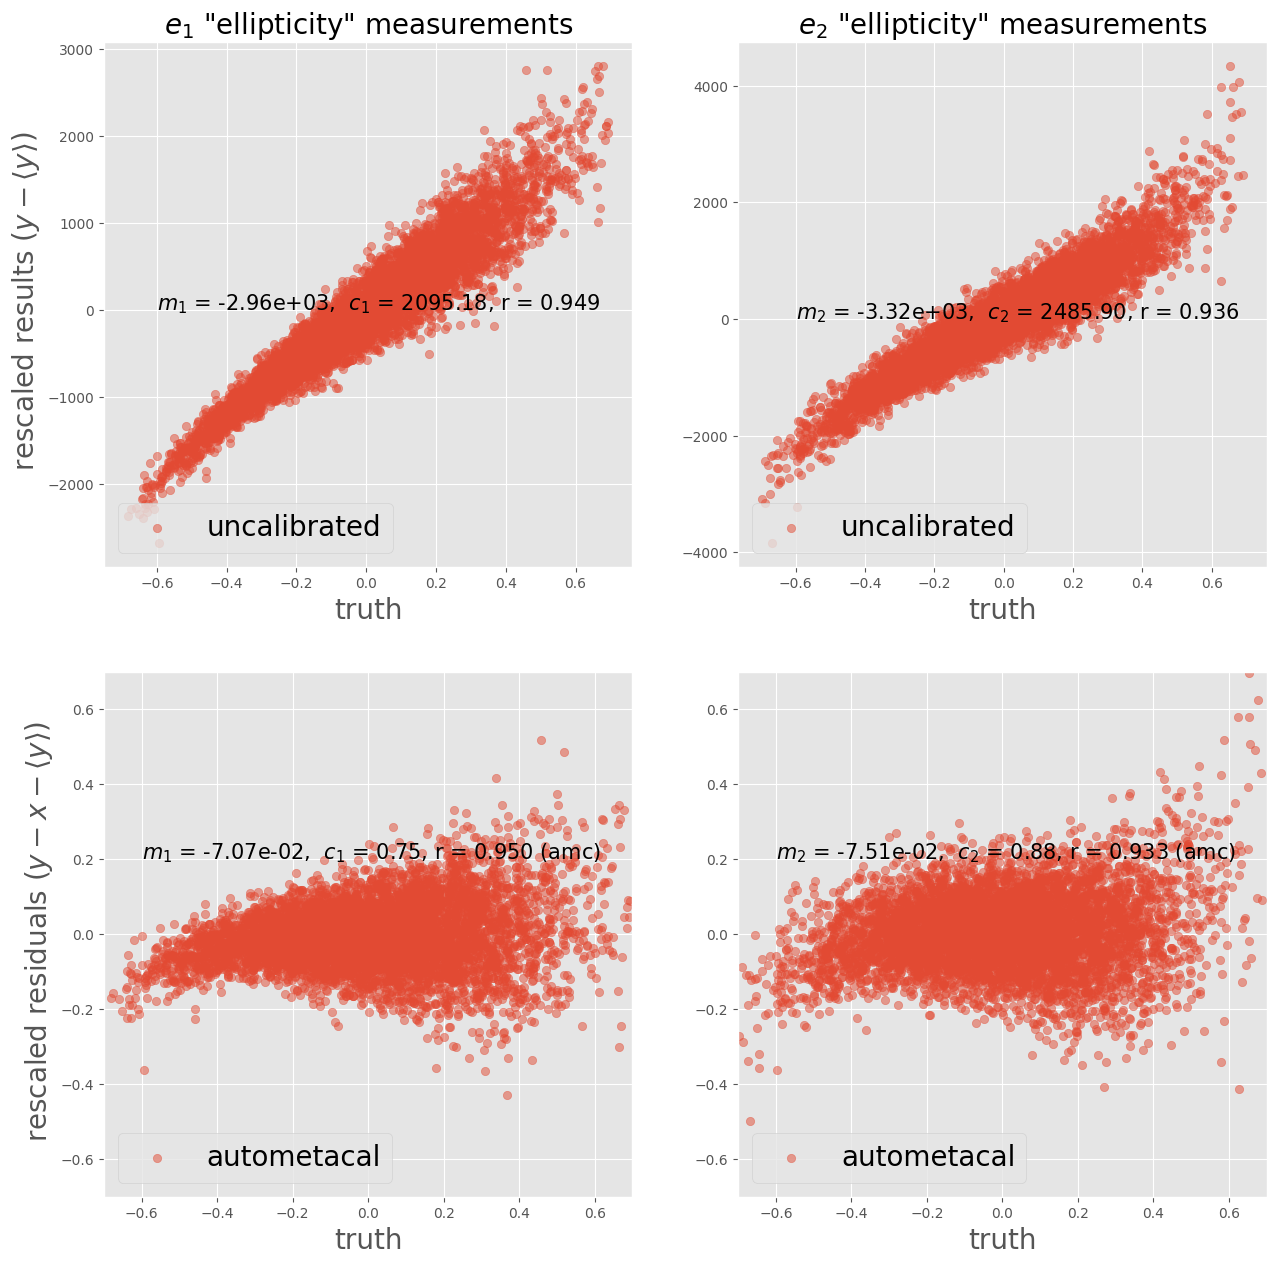

In [113]:
figure(figsize=(15,15))
style.use('ggplot')


x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


subplot(221)
scatter(x1,y1-mean(y1),alpha=.5,label="uncalibrated")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)

title("$e_1$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled results ($y - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)


subplot(223)
scatter(x1,y1corr-x1-mean(y1corr),alpha=.5,label="autometacal")
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)


xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y - x - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(222)

scatter(x2,y2-mean(y2),alpha=.5,label="uncalibrated")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

title("$e_2$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)


subplot(224)
scatter(x2,y2corr-x2-mean(y2corr),alpha=.5,label="autometacal")
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

xlim(-0.7,0.7)
ylim(-0.7,0.7)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)
savefig(f"prednewmodel{time.time()}.png",bbox_inches="tight")

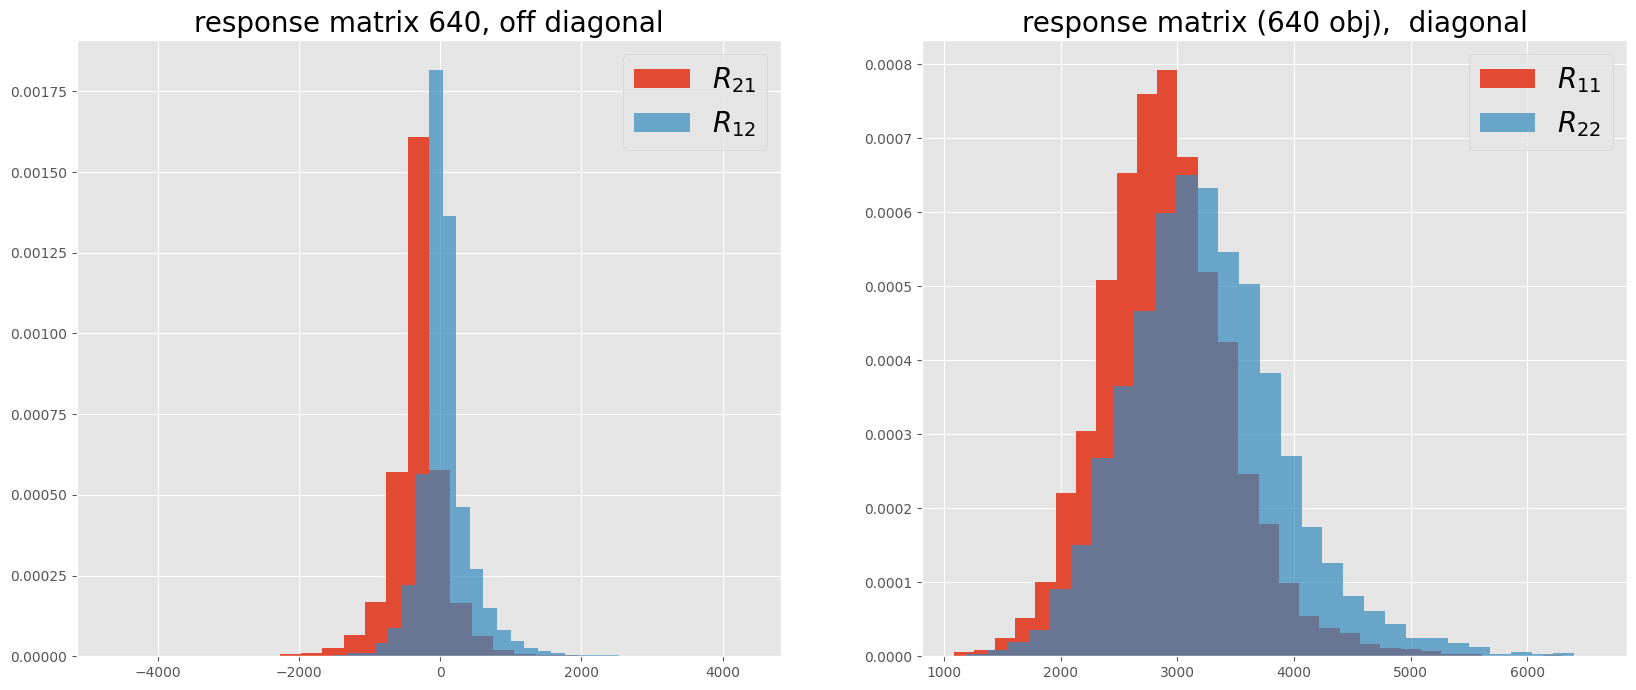

In [90]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("response matrix (640 obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("response matrix 640, off diagonal",fontsize=20)
legend(fontsize=20)
savefig(f'response_distribution_newmodel{time.time()}.pdf',bbox_inches='tight')

In [ ]:
banana();

## Testing the trained model in the wild: